# In this notebook I will use to Boston marathon 2014 data to experiment with clustering techniques

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [2]:
# read and displays the data
df = pd.read_csv('results_2014.csv')
print(df.shape)
df.head()

(31984, 21)


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
df.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

#### Check for null values

In [4]:
# get missing data
null_data = (df.isnull().sum() / len(df)) * 100

# remove columns without null values
null_data = null_data.drop(null_data[null_data == 0].index)
null_data

ctz      96.110555
state     8.054027
city      0.003127
dtype: float64

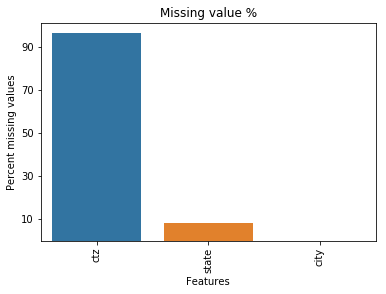

In [5]:
# plot missing data
f,ax = plt.subplots()
plt.xticks(rotation='90')

sns.barplot(x = null_data.index, y = null_data )
plt.yticks([10,30,50,70,90])
plt.title('Missing value %')
plt.ylabel('Percent missing values')
plt.xlabel('Features') 
plt.show()

handling
- ctz has about 96% missing values - drop column
- state - check into
- city - look into

In [6]:
# drop ctz column
df = df.drop('ctz', axis=1)

In [7]:
# look into state
state_df = df[['state', 'country', 'city', 'gender', 'age']]

# df with rows that state is null
state_null_df = state_df[state_df.isnull().any(axis=1)]

print(state_null_df.shape)

state_null_df.head()

(2576, 5)


,state,country,city,gender,age
0,NaN,JPN,Fukuoka,M,47
1,NaN,KEN,Eldoret,F,33
2,NaN,RSA,Paarl,M,41
3,NaN,ETH,Shoa,F,24
4,NaN,JPN,Nogata Fukuoka,M,40


In [8]:
# check if a runner from the US has missing value as state
state_null_df.loc[state_null_df['country'] == 'USA']

,state,country,city,gender,age


From above, it seems that runners who are not from the USA have a missing value in their 'state' feature, which make a lot for sense. Therefore, I'll replace it with 'N-USA' meaning kind of not from the US

In [9]:
df['state'] = df['state'].fillna('N-USA')

In [10]:
# look into the row with missing value at the city feature
df.loc[df['city'].isnull()]

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
14553,50.03,"Caires, Maria G.",243,127.08,F,54,226.27,16645,4730,184.87,14260,8.63,N-USA,155.30,25.22,106.45,100.78,BRA,NaN,213.47


To run a marathon at that age is very respectful; also as the only representative from Brazil, I don't want to dismiss her. This, I'll write 'BRA' as the city name.

In [11]:
# fill missing values
df['city'] = df['city'].fillna('BRA')

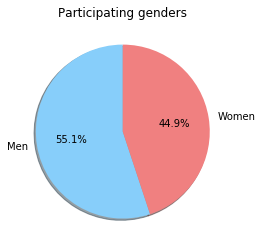

In [12]:
# men vs women 
labels = 'Men', 'Women'
sizes = [(df['gender'] == 'M').sum(), (df['gender'] == 'F').sum()]
colors = ['lightskyblue', 'lightcoral' ]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

plt.title('Participating genders')
plt.show()

In [13]:
# include the lower value; age groups are 
# idx 0: 0-20 yr, 
# idx 1: 20-30
# idx 2: 30-40, etc. 
# last group is 80+ 
age_list = []

for i in range(8):
    if i == 0:
        age_list.append((df['age'] < 20).sum())
    elif i == 7:
        age_list.append((df['age'] >= 80).sum())
    else:
        age_list.append(np.logical_and(df['age'] >= (i+1) * 10, df['age'] < (i+2) * 10).sum())
        
age_list

[74, 4901, 7951, 10193, 6515, 2110, 231, 9]

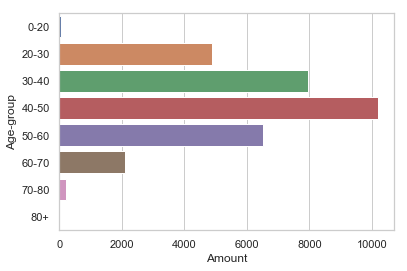

In [14]:
# plot the age groups
sns.set(style="whitegrid")

# df of groups and amounts
age_df = pd.DataFrame({'Age-group': ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'], 
                       'Amount': age_list})
ax = sns.barplot(x = 'Amount', y = 'Age-group', data=age_df )

plt.show()

In [15]:
# gets the count for each country
country_list = []
for c in df['country'].unique():
    country_list.append((df['country'] == c).sum())

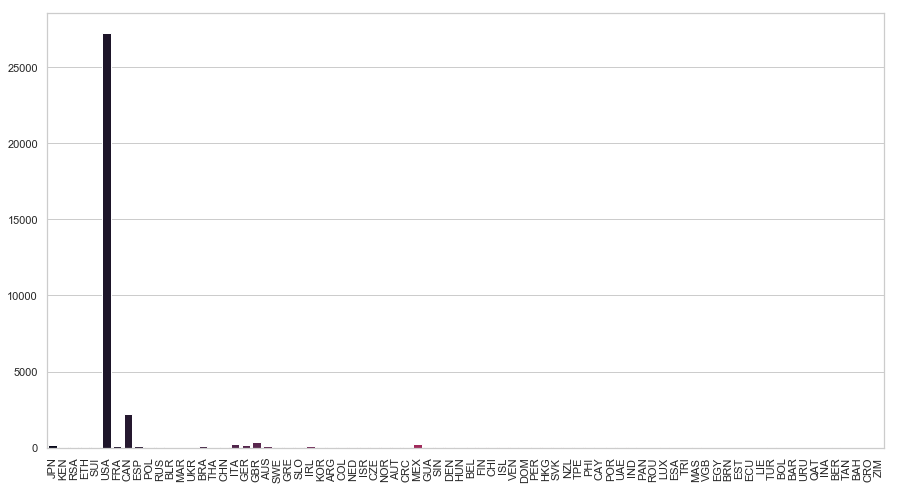

In [16]:
# plot the country count
f,ax = plt.subplots(figsize=(15,8))

plt.xticks(rotation='90')
sns.barplot(x=df['country'].unique(), y=country_list, palette='rocket')

USA and CAN have much higher volume. Thus, remove them and plot the countries again. Then I'll plot US states and CAN states

In [17]:
# remove USA and CAN
reduced_list = country_list
usa = (df['country'] == 'USA').sum()
canada = (df['country'] == 'CAN').sum()
reduced_list.remove(usa)
reduced_list.remove(canada)
countries = list(df['country'].unique())
countries.remove('USA')
countries.remove('CAN')

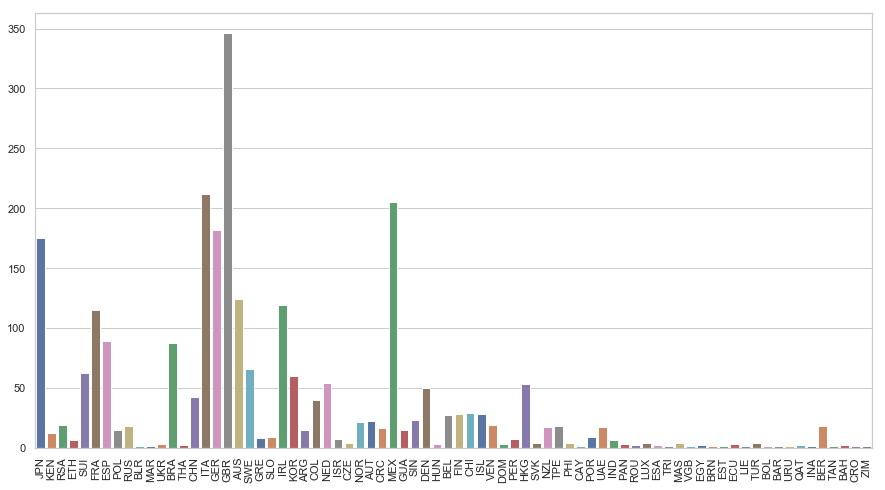

In [18]:
# plot reduced countries plot
f,ax = plt.subplots(figsize=(15,8))

plt.xticks(rotation='90')
sns.barplot(x=countries, y=reduced_list, palette="deep")

Plot only USA and CAN states

In [19]:
# USA states
# gets the count for each state
us_df = df[df['country'] == 'USA']
us_states_list = []
for s in us_df['state'].unique():
    us_states_list.append((us_df['state'] == s).sum())

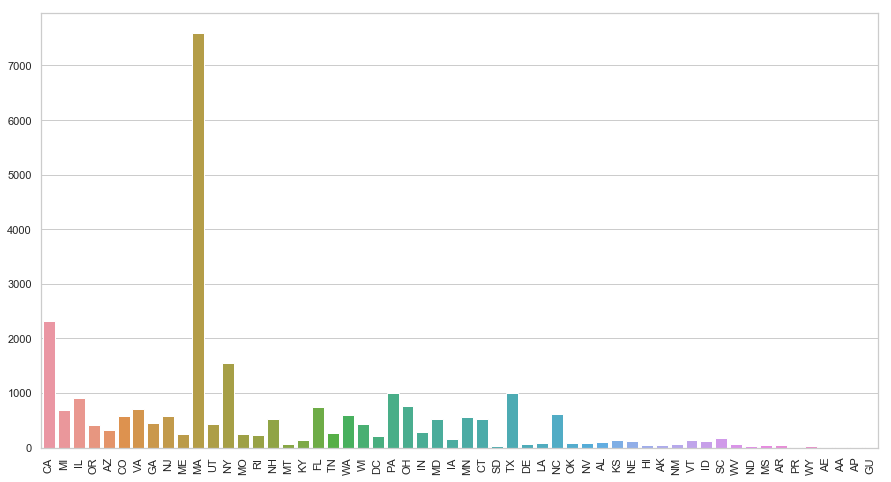

In [20]:
# plot the US states count
f,ax = plt.subplots(figsize=(15,8))

plt.xticks(rotation='90')
sns.barplot(x=us_df['state'].unique(), y=us_states_list)

In [21]:
# CAN states
# gets the count for each state
can_df = df[df['country'] == 'CAN']
can_states_list = []
for s in can_df['state'].unique():
    can_states_list.append((can_df['state'] == s).sum())

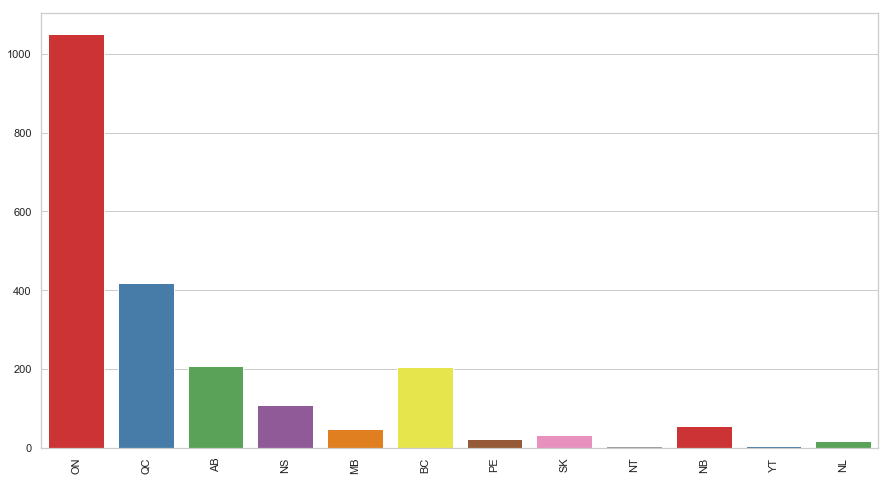

In [22]:
# plot the US states count
f,ax = plt.subplots(figsize=(15,8))

plt.xticks(rotation='90')
sns.barplot(x=can_df['state'].unique(), y=can_states_list, palette='Set1')
# sns.color_palette("muted")

In [23]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,N-USA,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,21,5.30,N-USA,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,N-USA,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,27,5.37,N-USA,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,N-USA,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [24]:
df.dtypes

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object

While working with the data, I saw that some columns had "-" value (such as below). To deal with that I'll cast the object functions that are really numeric to numeric (float/int) and then these values will turn to null, which I'll then replace  with their average running pace

In [25]:
df.iloc[3189]

10k                         -
name         Haushalter, Jeff
division                  647
25k                         -
gender                      M
age                        47
official               195.82
bib                      3622
genderdiv                4815
35k                    160.48
overall                  5463
pace                     7.48
state                      GA
30k                         -
5k                          -
half                        -
20k                         -
country                   USA
city                  Atlanta
40k                    184.62
Name: 3189, dtype: object

In [26]:
# change columns that are object but shouldn't be to numeric
numeric = ['10k','25k','age','official','35k','overall','pace','30k','5k','half','20k','40k']
df[numeric] = df[numeric].apply(pd.to_numeric, errors = 'coerce', axis=1)
print(df.dtypes)

10k          float64
name          object
division       int64
25k          float64
gender        object
age          float64
official     float64
bib           object
genderdiv      int64
35k          float64
overall      float64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object


In [27]:
# check again for null values
df.isnull().sum()

10k           50
name           0
division       0
25k          216
gender         0
age            0
official       0
bib            0
genderdiv      0
35k           34
overall        0
pace           0
state          0
30k           40
5k            52
half          72
20k           51
country        0
city           0
40k           39
dtype: int64

The pace is giving in min/mile (according to Kaggle); I'll round the number and say that 1 mile = 1.6 km and that a full marathon is 42 km.

In [28]:
# fill Na with -1 for easier replacement
df = df.fillna(-1)

# replace the -1 values with the average pace
columns = ['10k','25k','35k','30k','5k','half','20k','40k']

In [29]:
# replace the values where there was missing (running time) data with the pace multiple the km the runner ran (5k, 10, etc.)
for col in columns:
    if col == 'half': # half is 21 km
        df[col] = np.where(df[col] == -1, (21 / 1.6) * df['pace'], df[col])
    else:
        km = int(col.strip('k'))
        df[col] = np.where(df[col] == -1, (km / 1.6) * df['pace'], df[col])

In [30]:
# change gender to 0/1. Since the majority are males 1 = male, 0 = female
df['gender'] = np.where(df['gender']  == 'M', 1, 0)
df['gender'].unique()

array([1, 0], dtype=int64)

I'll ignore the object columns

In [31]:
# remove categorical features
df = df.select_dtypes(exclude='object')

df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,1,47.0,85.25,8,71.40,8.0,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,0,33.0,138.95,1,116.37,21.0,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,1,41.0,80.60,1,67.42,1.0,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,0,24.0,140.58,3,116.37,27.0,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,1,40.0,81.23,2,67.83,2.0,3.10,57.03,8.02,38.60,36.58,76.72


In [32]:
# normalize the data
X = normalize(df)

In [33]:
# before modeling
def model_prep(df):
    # normelize data
    X = normalize(df)
    
    # split to two 
    half_pt = int(X.shape[0] / 2)
    X1 = X[:half_pt]
    X2 = X[half_pt:]
    
    # for visualization keep 2 features only
    pca = PCA(n_components=2)
    X1_pca = pca.fit_transform(X1)
    X2_pca = pca.fit_transform(X2)
    
    return X1, X1_pca, X2, X2_pca

In [34]:

# dictionary to store labels for each iteration
dic1 = {}
dic2 = {}
def train_model(model, X1, X1_pca, X2, X2_pca, max_k): # max_k = 0 for mean-shift
    # if not mean-shift/ bdhdc

    for i in range(2, max_k , 2):    # starts with 2 clusters goes up to k increament by 2
        m = model(n_clusters=i, random_state=24)

        # FOR X1:

        m.fit(X1)
        m.fit(X1_pca)

        # save labels
        dic1["k-{}".format(i)] = m.labels_

       
        # plot (only 2 features from pca)
        f = plt.figure(figsize=(10,4))
        
        plt.subplot(121)
        plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c = m.labels_, s=50, cmap='viridis')
        plt.title("X1_pca sample")

        silhouette_score_X1 = metrics.silhouette_score(X1, m.labels_)


        # FOR X2:
        m.fit(X2)
        m.fit(X2_pca)

        # save labels
        dic2["k-{}".format(i)] = m.labels_


        # X2_pca plot 
        plt.subplot(122)
        plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c = m.labels_, s=50, cmap='viridis')
        plt.title("X2_pca sample")

        silhouette_score_X2 = metrics.silhouette_score(X2, m.labels_)

        # num of cluster title
        plt.suptitle(f'{i} Clusters', fontsize=20)
        plt.show()

        # silhouette_score = (b - a) / max(a, b)
        # a = mean intra-cluster distance
        # b = mean nearest-cluster distance (the distance between a sample and the nearest cluster that the sample is not a part of)
        print("silhouette score for X1:", silhouette_score_X1)
        print("silhouette score for X2:", silhouette_score_X2)

In [35]:
def train_model_noK(model, X1, X1_pca, X2, X2_pca):
    # for mean shift model
    if model == MeanShift:
        # X1:
        bandwidth1 = estimate_bandwidth(X1, quantile=0.2, n_samples=15000)

        cluster1 = MeanShift(bandwidth=bandwidth1, bin_seeding=True)
        
        # X2:
        bandwidth2 = estimate_bandwidth(X2, quantile=0.2, n_samples=15000)

        cluster2 = MeanShift(bandwidth=bandwidth2, bin_seeding=True)

    
    # for DBSCAN model
    elif model == DBSCAN:
        cluster1 = DBSCAN(eps=0.3, min_samples=10000)
        cluster2 = DBSCAN(eps=0.3, min_samples=10000)
        
    else:
        cluster1 = AffinityPropagation(damping=0.6, convergence_iter=10)
        cluster2 = AffinityPropagation(damping=0.6, convergence_iter=10)
        
    
    # train on x1 and get values
    cluster1.fit(X1)
    # check how many clusters
    X1_ncluster = len(np.unique(cluster1.labels_))
    silhouette_score_X1 = metrics.silhouette_score(X1, cluster1.labels_)
    
    # save labels from X1
    labels1 = [cluster1.labels_]
    
    # train on x2 and get values
    cluster2.fit(X2)
    # check how many clusters
    X2_ncluster = len(np.unique(cluster2.labels_))
    silhouette_score_X2 = metrics.silhouette_score(X2,  cluster2.labels_)
    
    # save labels from X1
    labels2 = [cluster2.labels_]

    # plot (using only 2 features from pca)
    f = plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.scatter(X1_pca[:, 0], X1_pca[:, 1], c = cluster1.labels_, s=50, cmap='viridis')
    plt.title("X1_pca sample")

    plt.subplot(122)
    plt.scatter(X2_pca[:, 0], X2_pca[:, 1], c = cluster2.labels_, s=50, cmap='viridis')
    plt.title("X2_pca sample")

    plt.show()

    print("Number of clusters for X1: {}, silhouette score: {}".format(X1_ncluster, silhouette_score_X1))
    print("Number of clusters for X2: {}, silhouette score: {}".format(X2_ncluster, silhouette_score_X2))
    return labels1, labels2 

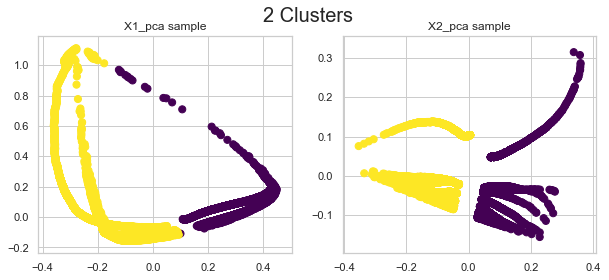

silhouette score for X1: 0.5068711274220818
silhouette score for X2: 0.465598848440429


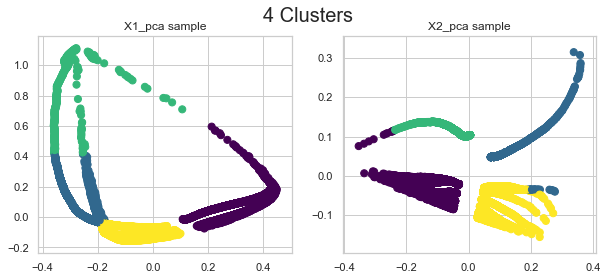

silhouette score for X1: 0.6009882875164594
silhouette score for X2: 0.6417945812518884


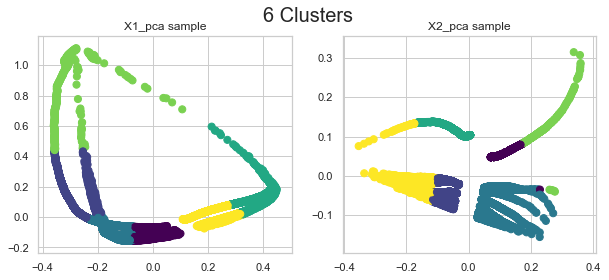

silhouette score for X1: 0.41185644071209515
silhouette score for X2: 0.6175446758090489


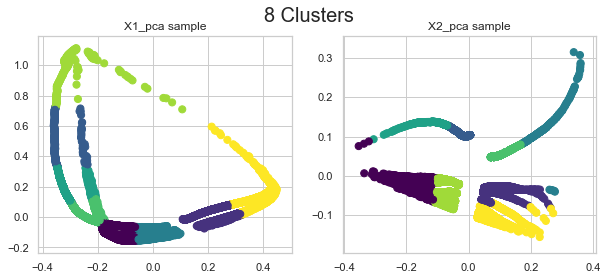

silhouette score for X1: 0.4164251304068734
silhouette score for X2: 0.5919706690858099


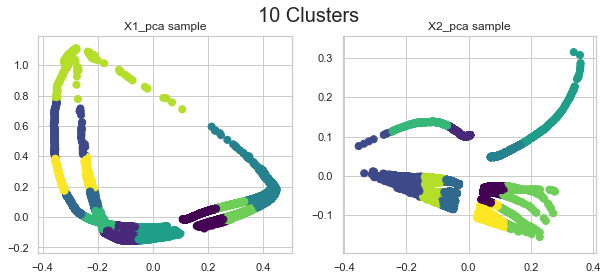

silhouette score for X1: 0.3846524638048818
silhouette score for X2: 0.5668343661922802


In [36]:
# K means
X1, X1_pca, X2, X2_pca = model_prep(df)

train_model(KMeans, X1, X1_pca, X2, X2_pca, 12)

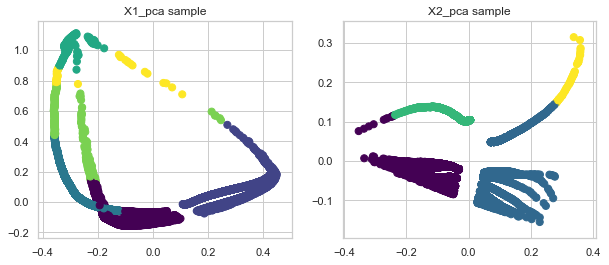

Number of clusters for X1: 6, silhouette score: 0.6176262187898631
Number of clusters for X2: 4, silhouette score: 0.577013776374062


In [37]:
# Mean shift
X1, X1_pca, X2, X2_pca = model_prep(df)

ms_labels1, ms_labels2 = train_model_noK(MeanShift, X1, X1_pca, X2, X2_pca)


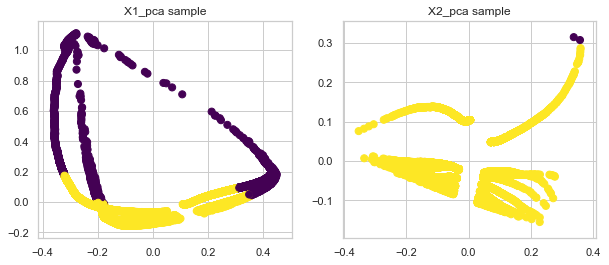

Number of clusters for X1: 2, silhouette score: 0.4115945801402762
Number of clusters for X2: 2, silhouette score: 0.7507835119065724


In [38]:
# DBSCAN
X1, X1_pca, X2, X2_pca = model_prep(df)

db_labels1, db_labels2 = train_model_noK(DBSCAN, X1, X1_pca, X2, X2_pca)


In [39]:
# # TO SLOW
# # SpectralClustering
# X1, X1_pca, X2, X2_pca = model_prep(df)

# train_model(SpectralClustering, X1, X1_pca, X2, X2_pca, 12)

In [40]:
# # TO SLOW
# # SpectralClustering
# X1, X1_pca, X2, X2_pca = model_prep(df)

# train_model_noK(AffinityPropagation, X1, X1_pca, X2, X2_pca)

### Next, look into the clusters. 
Since there are two of them (each half the length of the main df), I'll work with each one to see if they give some different results/ insights 

In [41]:
half_pt = int(len(df) / 2)
# df of the first half 
df1 = df.copy()
df1 = df1[:half_pt]
# second half
df2 = df.copy()
df2 = df[half_pt:]

In [42]:
# add the key (k) value (v) pair for k-means for df1 and df2
for k, v in dic1.items():
    for d in [df1, df2]:
        d["kmeans_x1_{}".format(k)] = v
        
# add the labels from mean-shift
df1['mean-shift'] = ms_labels1[0]
df2['mean-shift'] = ms_labels2[0]

# add labels from DBSCAN
df1['dbscan'] = db_labels1[0]
df2['dbscan'] = db_labels2[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

In [43]:
x1_k2 = df1[df1['kmeans_x1_k-2'] == 1]
x1_k2 = x1_k2.iloc[:, :15]


x2_k2 = df2[df2['kmeans_x1_k-2'] == 1]
x2_k2 = x2_k2.iloc[:, :15]

In [44]:
x2_k2.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.000000,10801.00000,10801.000000,10801.000000
mean,57.257783,2140.200352,149.585549,0.381446,46.034164,272.434344,10499.384964,220.737029,22000.293214,10.397720,184.065009,28.407474,124.07183,117.458746,257.011915
std,7.086630,1928.858657,22.670791,0.485764,11.847083,44.624480,3787.195800,35.901307,5963.960169,1.697288,28.895407,3.349737,17.41808,16.400035,42.175742
min,36.250000,1.000000,70.000000,0.000000,18.000000,164.220000,279.000000,134.250000,537.000000,6.270000,113.650000,17.820000,79.32000,75.320000,155.170000
25%,52.270000,608.000000,133.650000,0.000000,38.000000,237.970000,7671.000000,194.130000,17544.000000,9.080000,163.280000,26.080000,111.90000,106.020000,224.800000
50%,55.580000,1457.000000,143.350000,0.000000,46.000000,262.400000,10801.000000,211.680000,22250.000000,10.020000,176.370000,27.650000,119.37000,113.030000,247.150000
75%,61.020000,3418.000000,160.350000,1.000000,55.000000,297.250000,13407.000000,240.200000,26946.000000,11.350000,199.000000,30.250000,132.67000,125.580000,280.570000
max,112.380000,6979.000000,289.020000,1.000000,81.000000,538.880000,17575.000000,439.820000,31931.000000,20.570000,367.200000,86.950000,236.67000,224.350000,508.170000


In [45]:
np.unique(ms_labels1)

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [46]:
c1 = df1[df1['kmeans_x1_k-4'] == 0].iloc[:, :15]
c2 = df1[df1['kmeans_x1_k-4'] == 1].iloc[:, :15]
c3 = df1[df1['kmeans_x1_k-4'] == 2].iloc[:, :15]
c4 = df1[df1['kmeans_x1_k-4'] == 3].iloc[:, :15]

K means first cluster:

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


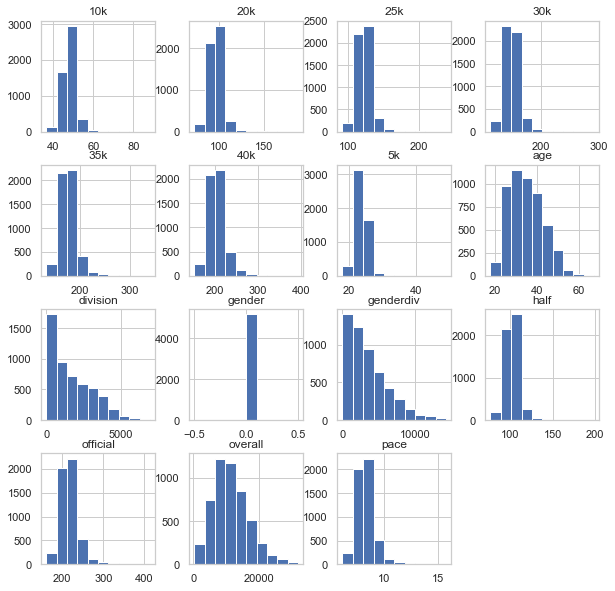

In [47]:
f = plt.figure(figsize=(10,10))
ax = f.gca()
c1.hist(ax=ax)
plt.show()

In [48]:
c1.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,5175.000000,5175.000000,5175.000000,5175.0,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000,5175.000000
mean,47.890165,1669.577005,122.640437,0.0,34.717488,217.879523,3455.712464,177.642050,11453.361353,8.318263,149.521250,23.845562,102.584661,97.168473,205.792354
std,3.595480,1402.759092,10.517974,0.0,8.024086,22.966217,2699.812073,17.487059,5405.471197,0.876131,13.727862,1.758336,8.349712,7.850928,21.521316
min,36.470000,1.000000,92.050000,0.0,18.000000,161.600000,28.000000,133.450000,401.000000,6.170000,112.320000,18.200000,77.320000,73.300000,153.220000
25%,45.970000,454.500000,116.900000,0.0,28.000000,204.290000,1341.500000,167.820000,7577.500000,7.800000,142.000000,22.920000,98.030000,92.875000,193.175000
50%,47.900000,1319.000000,122.000000,0.0,34.000000,214.930000,2830.000000,175.720000,10807.000000,8.200000,148.350000,23.850000,102.230000,96.870000,203.080000
75%,49.540000,2663.500000,127.070000,0.0,40.000000,227.430000,4938.500000,184.700000,14591.500000,8.680000,155.100000,24.640000,106.200000,100.600000,214.540000
max,88.230000,6950.000000,238.350000,0.0,67.000000,413.570000,14295.000000,339.530000,31808.000000,15.780000,291.850000,48.830000,198.450000,187.620000,392.100000


Second cluster:

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


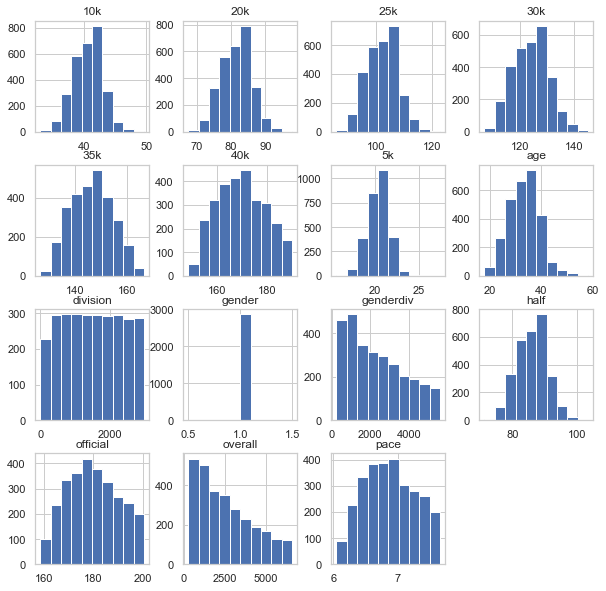

In [49]:
f = plt.figure(figsize=(10,10))
ax = f.gca()
c2.hist(ax=ax)
plt.show()

In [50]:
c2.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,2866.000000,2866.000000,2866.000000,2866.0,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000,2866.000000
mean,40.637802,1504.719470,102.245359,1.0,32.790300,179.823440,2338.676204,146.464471,2552.233775,6.866947,123.882317,20.372525,86.022706,81.547191,169.600879
std,2.309967,851.305962,5.436756,0.0,5.972624,10.319535,1464.135166,7.852365,1672.620281,0.393680,6.544027,1.214612,4.629044,4.397168,9.540794
min,32.970000,1.000000,86.050000,1.0,18.000000,158.520000,250.000000,126.920000,276.000000,6.050000,106.530000,15.650000,71.470000,67.570000,148.530000
25%,38.980000,790.250000,98.170000,1.0,28.000000,171.620000,1044.250000,140.390000,1100.250000,6.550000,118.970000,19.520000,82.600000,78.320000,161.925000
50%,40.820000,1509.500000,102.520000,1.0,33.000000,179.280000,2093.000000,146.700000,2214.000000,6.850000,124.075000,20.480000,86.180000,81.700000,169.430000
75%,42.300000,2233.750000,106.095000,1.0,37.000000,187.765000,3422.500000,152.200000,3701.500000,7.170000,128.420000,21.220000,89.330000,84.700000,176.980000
max,49.600000,2975.000000,122.780000,1.0,58.000000,200.400000,5592.000000,166.480000,6562.000000,7.650000,145.320000,27.350000,103.280000,97.750000,189.950000


Third cluster:

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


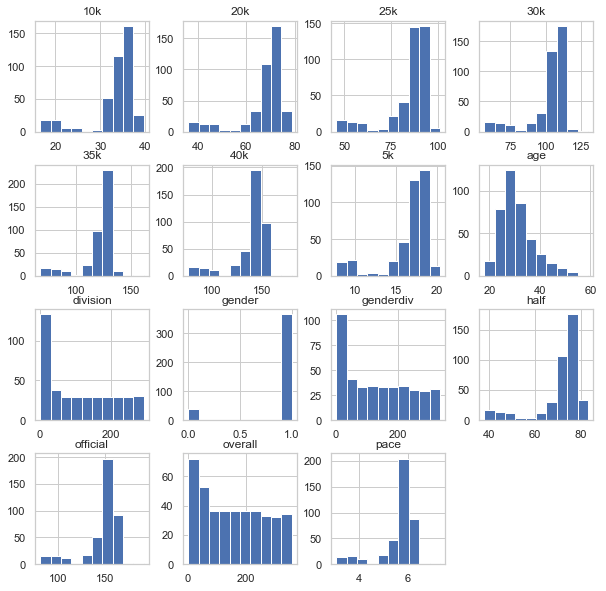

In [51]:
f = plt.figure(figsize=(10,10))
ax = f.gca()
c3.hist(ax=ax)
plt.show()

In [52]:
c3.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,33.271386,109.608911,84.485965,0.905941,31.274752,146.684480,134.784653,120.667649,157.589109,5.602698,102.336955,16.528020,71.068837,67.379950,138.575965
std,5.168083,93.453113,11.580681,0.292273,6.597334,19.357413,103.965688,15.575386,109.054995,0.738394,13.520818,2.784831,9.946950,9.433049,18.344600
min,16.620000,1.000000,45.800000,0.000000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,32.682500,20.000000,83.900000,1.000000,27.000000,145.695000,32.000000,119.730000,51.000000,5.570000,101.807500,16.230000,70.627500,66.922500,137.917500
50%,34.880000,90.500000,88.260000,1.000000,30.000000,154.090000,122.500000,126.500000,149.500000,5.880000,106.890000,17.410000,74.140000,70.315000,145.690000
75%,36.400000,191.250000,91.477500,1.000000,34.000000,157.872500,223.250000,129.580000,250.250000,6.030000,110.370000,18.172500,77.120000,73.120000,149.035000
max,39.650000,292.000000,101.080000,1.000000,59.000000,191.330000,334.000000,161.520000,361.000000,7.300000,130.020000,20.330000,83.050000,78.820000,180.400000


Forth cluster:

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


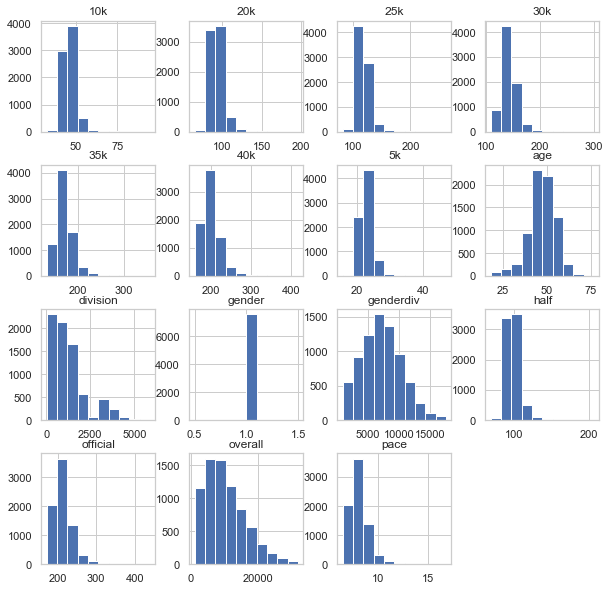

In [54]:
f = plt.figure(figsize=(10,10))
ax = f.gca()
c4.hist(ax=ax)
plt.show()

In [55]:
c4.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,7547.000000,7547.000000,7547.000000,7547.0,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000
mean,45.985006,1212.400159,117.644764,1.0,47.358951,213.450216,7250.162846,171.854992,10224.545647,8.149311,143.810328,22.919578,98.395457,93.190935,200.762283
std,4.017755,995.397782,11.759748,0.0,7.744483,26.262723,3182.732314,19.721431,6010.413269,1.001658,15.391721,1.931842,9.319995,8.768564,24.366762
min,32.120000,1.000000,82.230000,1.0,18.000000,171.120000,1003.000000,132.620000,1057.000000,6.530000,109.230000,15.680000,68.730000,65.150000,159.700000
25%,43.200000,481.000000,109.925000,1.0,43.000000,196.700000,4938.000000,159.425000,5634.000000,7.520000,133.970000,21.600000,92.090000,87.230000,185.350000
50%,45.630000,988.000000,116.180000,1.0,48.000000,209.220000,7091.000000,168.900000,9071.000000,7.980000,141.700000,22.770000,97.370000,92.230000,196.830000
75%,48.180000,1584.000000,122.940000,1.0,53.000000,224.600000,9341.500000,179.850000,13794.500000,8.570000,150.270000,24.020000,102.900000,97.450000,210.980000
max,94.830000,5898.000000,262.031250,1.0,77.000000,440.080000,17563.000000,357.600000,31911.000000,16.770000,300.680000,46.980000,207.220000,196.120000,416.330000


#### Some insights 
All clusters did pretty good job recognizing gender<br>
The forth cluster is the largest one built only from male runners<br>
Cluster #4 has also the oldest person<br>
Culster #3 has the fastest average time and (supresiling) the fastest runner<br>
That cluster also has the average of the youngest runners (which make sense). It's also the smallest cluster our of the 4.

Mean shift

In [56]:
ms1 = df1[df1['mean-shift'] == 0].iloc[:,:15]
ms2 = df1[df1['mean-shift'] == 1].iloc[:,:15]
ms3 = df1[df1['mean-shift'] == 2].iloc[:,:15]
ms4 = df1[df1['mean-shift'] == 3].iloc[:,:15]
ms5 = df1[df1['mean-shift'] == 4].iloc[:,:15]
ms6 = df1[df1['mean-shift'] == 5].iloc[:,:15]

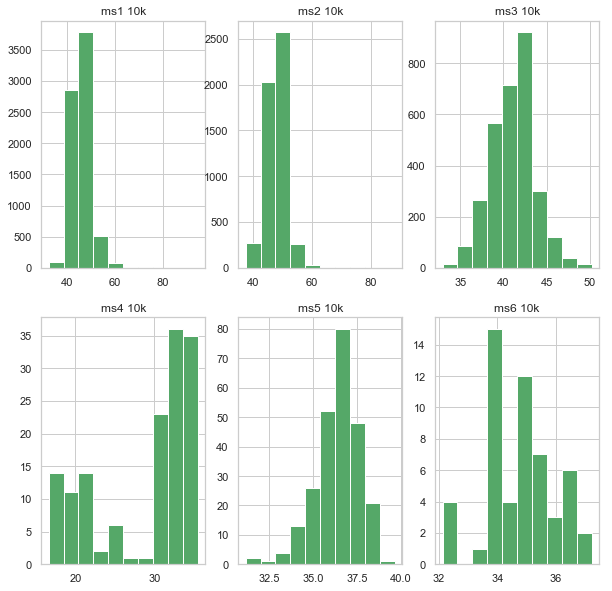

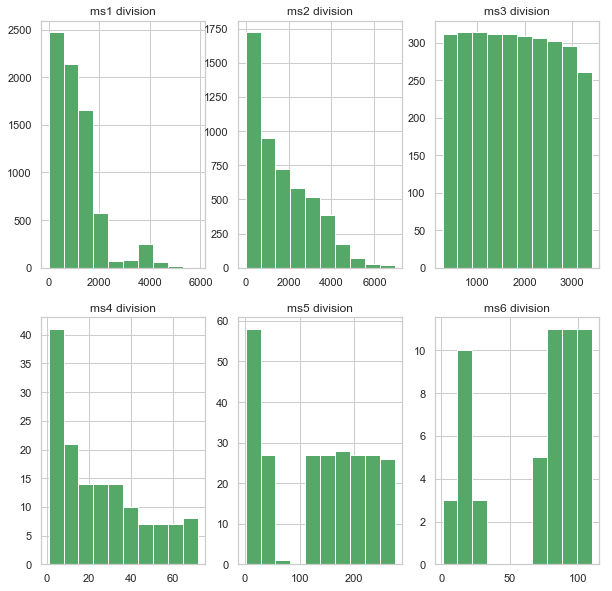

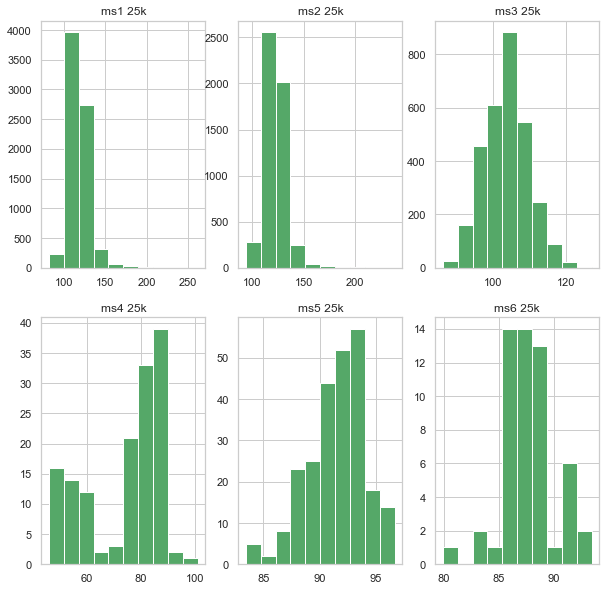

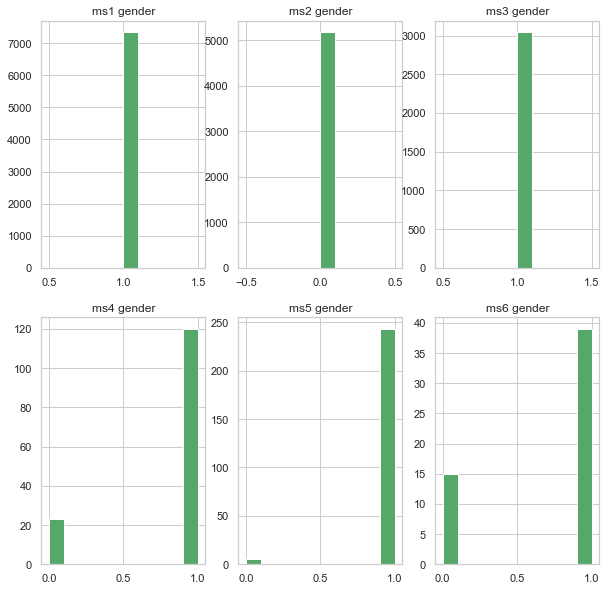

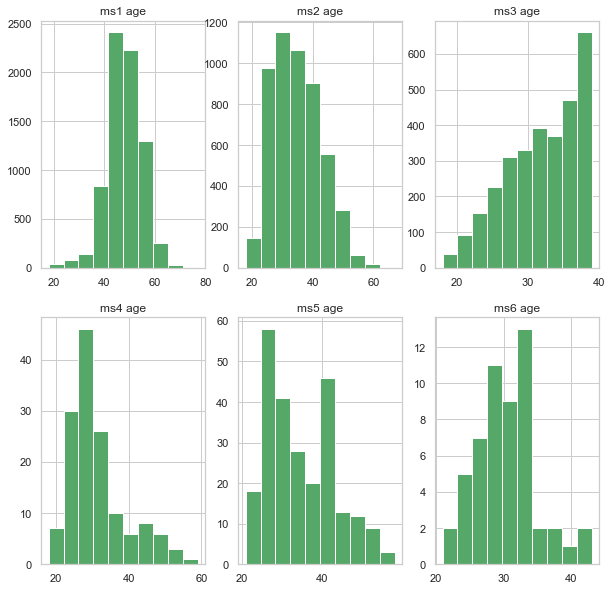

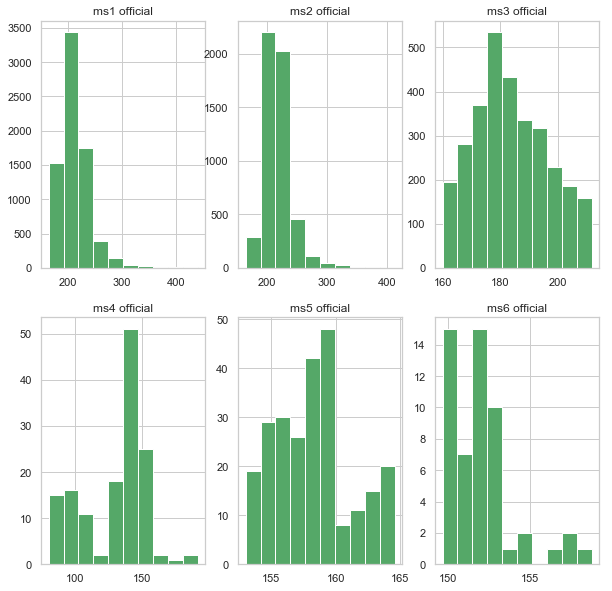

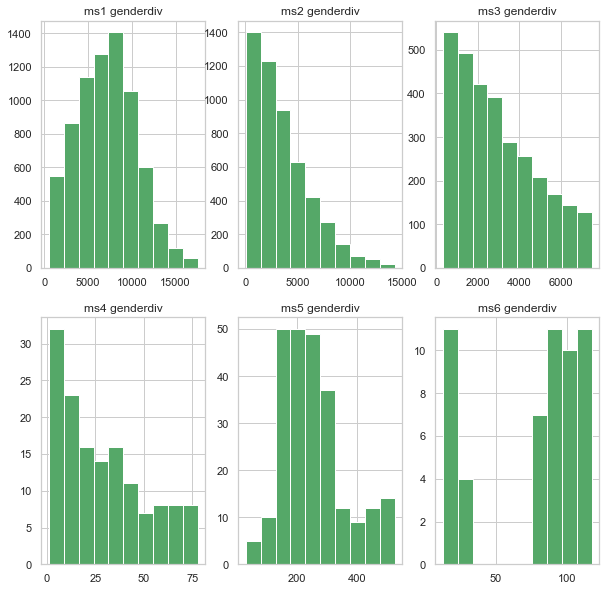

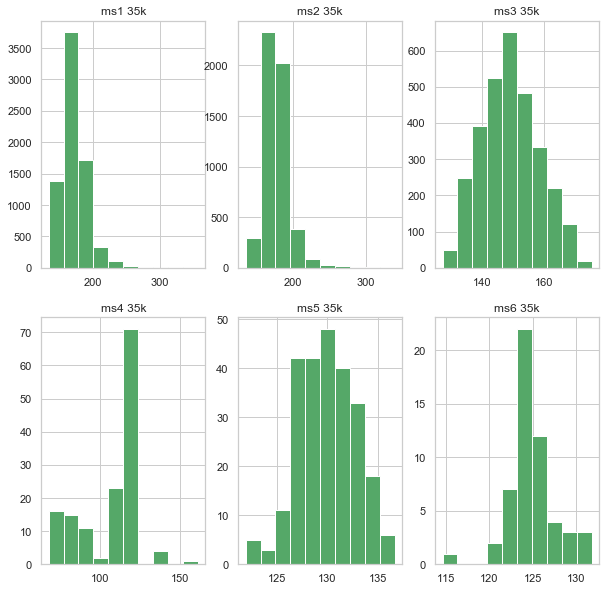

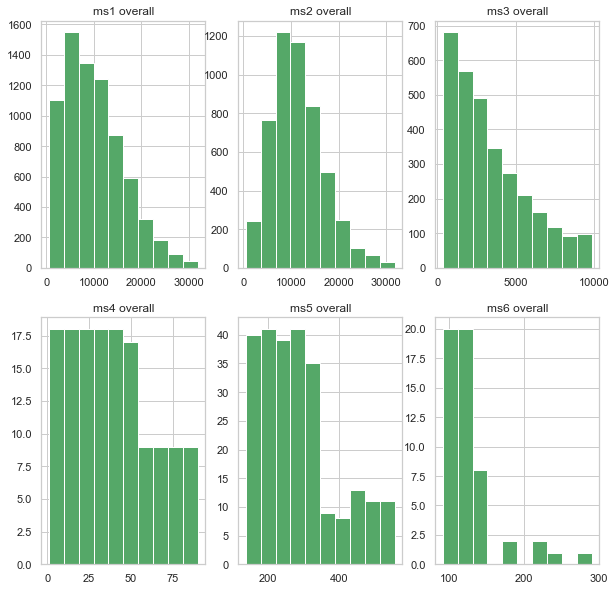

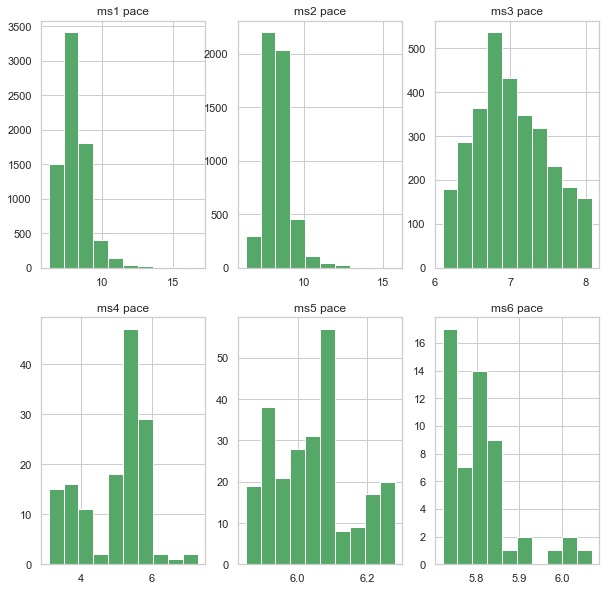

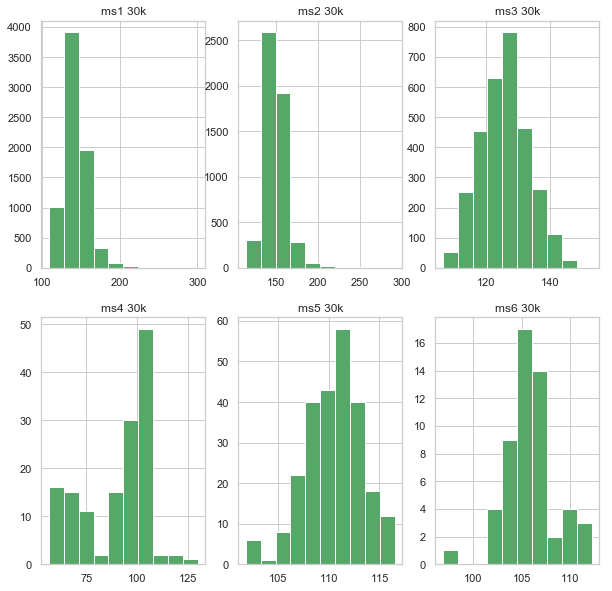

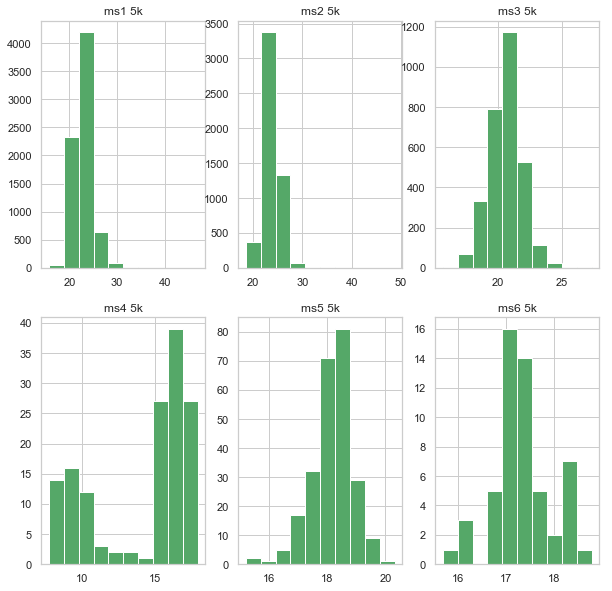

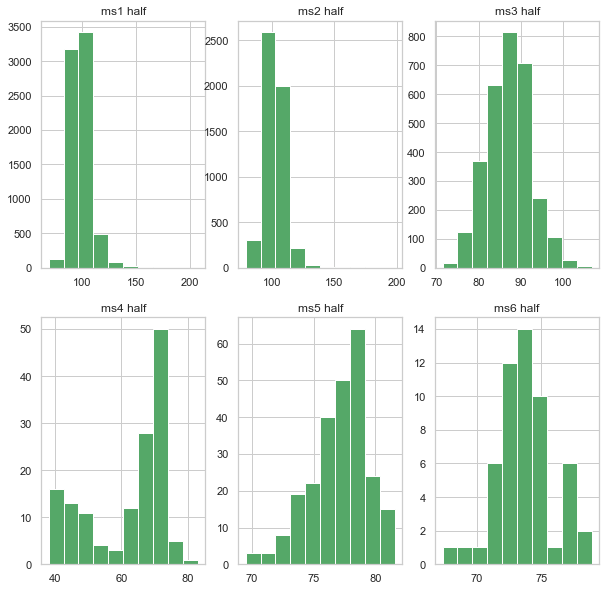

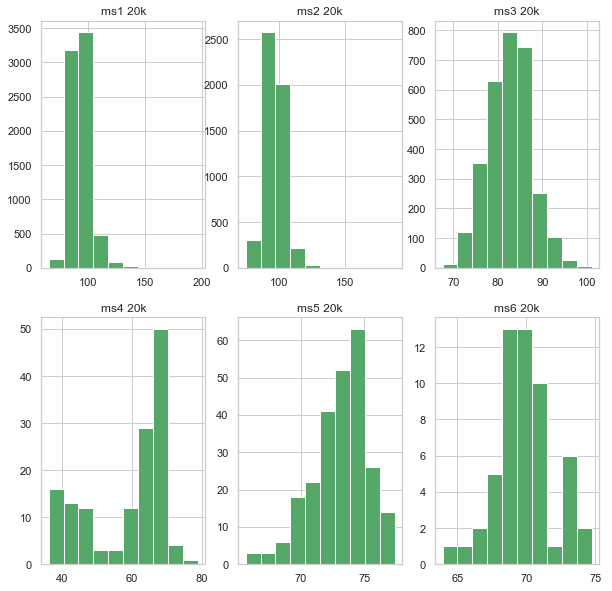

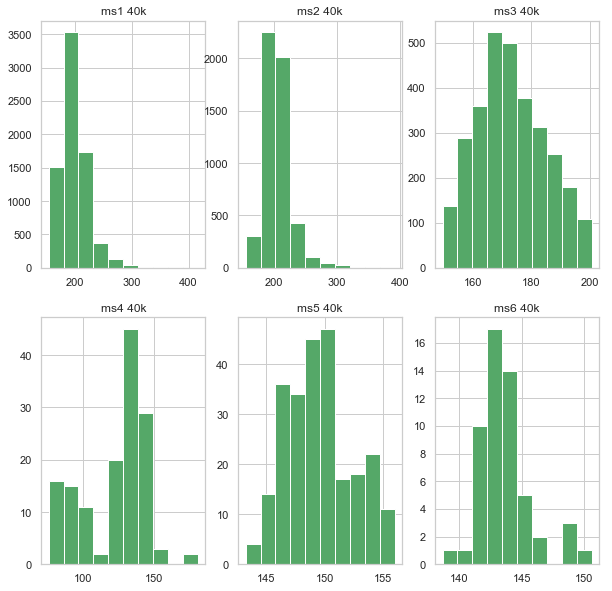

In [57]:
for col in ms1.columns:
    i = 1
    f = plt.figure(figsize=(10,10))
    for d in [ms1, ms2, ms3, ms4, ms5, ms6]:
        place = int(str(23) + str(i))
        plt.subplot(place)
        d[col].hist(color='g')
        plt.title("ms{} {}".format(i, col))
        i += 1
        
    plt.show()
    print("\n")

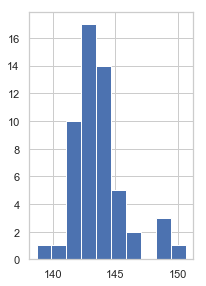

In [58]:
f = plt.figure(figsize=(10,10))

plt.subplot(231)
d[col].hist()


dbscan

In [59]:
df1.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,...,half,20k,40k,kmeans_x1_k-2,kmeans_x1_k-4,kmeans_x1_k-6,kmeans_x1_k-8,kmeans_x1_k-10,mean-shift,dbscan
0,17.37,8,47.67,1,47.0,85.25,8,71.40,8.0,3.27,...,39.72,37.65,80.43,1,2,4,6,8,3,-1
1,32.58,1,82.43,0,33.0,138.95,1,116.37,21.0,5.30,...,69.47,65.83,132.10,1,2,4,6,8,3,-1
2,16.62,1,45.80,1,41.0,80.60,1,67.42,1.0,3.08,...,38.03,36.10,76.10,1,2,4,6,8,3,-1
3,32.57,3,82.43,0,24.0,140.58,3,116.37,27.0,5.37,...,69.47,65.83,132.95,1,2,4,6,8,3,-1
4,17.12,2,46.37,1,40.0,81.23,2,67.83,2.0,3.10,...,38.60,36.58,76.72,1,2,4,6,8,3,-1


In [60]:
db1 = df1[df1['dbscan'] == -1].iloc[:,:15]


In [61]:
db1.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,41.675643,431.269689,105.126521,0.349597,33.515175,182.460615,696.596619,149.919282,3875.225893,6.967234,127.209425,20.841192,88.436476,83.837536,172.486177
std,5.346480,373.451318,13.020071,0.476934,7.640967,22.349752,478.459643,18.365575,3032.458392,0.852368,15.645790,2.744013,10.985820,10.417071,21.207243
min,16.620000,1.000000,45.800000,0.000000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,37.920000,96.000000,95.210000,0.000000,27.000000,165.220000,300.000000,135.630000,599.500000,6.320000,115.070000,18.990000,80.300000,76.130000,156.145000
50%,43.100000,344.000000,109.400000,0.000000,32.000000,191.000000,627.000000,156.620000,4324.000000,7.300000,132.830000,21.570000,91.820000,86.970000,180.450000
75%,45.875000,671.000000,115.550000,1.000000,39.000000,201.275000,1042.500000,165.120000,6766.500000,7.680000,139.925000,22.970000,97.220000,92.130000,190.225000
max,50.050000,1310.000000,124.220000,1.000000,59.000000,207.830000,1789.000000,172.980000,8630.000000,7.930000,148.800000,25.070000,104.880000,99.380000,197.020000
